### Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import keras
import time
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, Input, add
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
from IPython.core.display import HTML

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Read in raw count microbial data, ground truth methane production rate, and pH data.

In [2]:
X = pd.read_csv("X.csv", index_col=0).astype("int32")
X.columns = X.columns.astype("int16")
Y = pd.read_csv("Y.csv", index_col=0)
ph = pd.read_csv("ph.csv", index_col=0)
lrp = pd.read_csv("lrp_features/50_features_lrp.csv", index_col=0)

In [3]:
X.head(10)

,1,2,3,4,5,6,7,8,9,10,...,480,481,482,483,484,485,486,487,488,489
AK1,0,0,0,0,0,0,4,0,0,3,...,2,0,0,0,0,0,0,0,0,0
AK2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,0
AK3,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,14,0,0,0
AL1,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,5,0,0,0
AL2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AR1,0,0,0,0,0,0,2,4,2,0,...,3,3,0,0,0,0,0,0,0,0
AR2,0,0,0,0,0,0,0,4,0,0,...,0,2,0,0,0,0,0,0,2,0
AR3,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
AZ1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,226,0,0,0,0,0,0


In [4]:
Y.head(10)

,Methane Production Rate (L-CH4/L-Day)
AK1,0.316717
AK2,0.330988
AK3,0.387566
AL1,0.427573
AL2,0.485379
AL3,0.543996
AR1,0.240452
AR2,0.236394
AR3,0.274703
AZ1,0.502874


### Define and compile model

In [5]:
def build_model(input_shape, lr=0.001, loss="mse", dropout=0.1):
    # Define model
    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=input_shape),
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu'),
        keras.layers.Dropout(dropout),
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=128, kernel_size=1, activation='relu'),
        keras.layers.Dropout(dropout),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Dropout(dropout),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
        keras.layers.Dropout(dropout),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Dropout(dropout),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)
    ])

    # Compile Model
    model.compile(loss=loss, optimizer=Adam(lr=lr))
    
    return model
# Show model summary
build_model(X.shape).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 149, 128)          62720     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 149, 128)          16512     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 128)          16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 149, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 149, 128)          16512     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 149, 128)          16512     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 149, 128)          16512     
__________

### Leave-one-out Cross Validation

In [6]:
cv_results = pd.DataFrame(index=["Prediction", "Observed", "Error", "pH"])

fold = X.shape[0]
tik = time.time()

for i in range(fold):
    
    # Reset keras session to reduce model clutter.
    keras.backend.clear_session()
    
    # Select validation sample.
    sample = X.iloc[i].name
    # Get pH data for the validation sample.
    pH = ph.loc[sample][0]
    
    # Seperate validation sample and training samples and select relevant features for the given validation sample.
    X_train = X.drop(sample)[lrp[sample]]
    X_val = X.iloc[[i]][lrp[sample]]
    Y_train = Y.drop(sample)
    Y_val = Y.iloc[[i]]
    
    # Reshape Data for 1D CNN.
    X_train = np.asarray(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
    X_val = np.asarray(X_val).reshape((X_val.shape[0],X_val.shape[1],1))
    Y_train = np.asarray(Y_train)
    Y_val = np.asarray(Y_val)
  
    # Reset model from previous fold's training.
    model = build_model((X_train.shape[1],1))
    # Train the model on the training samples.
    model.fit(X_train, Y_train, batch_size=32, epochs=100, verbose=0)
    
    # Record model prediction, observed value, and error on validation sample
    prediction = model.predict(X_val)[0][0]
    observed = Y_val[0][0]
    error = np.square(prediction - observed)
    
    # Display training information
    print("\n==========[ ", i+1, "/", fold," ]==========", sep="")
    print("Sample:", sample, "\nCNN Predicition:", prediction, "\nObserved:", observed, "\nError:", error, "\npH:", pH)
    
    # Cache training information
    cv_results[sample] = (prediction, observed, error, pH)

# Transpose
cv_results = cv_results.T
# Display elapsed time
tok = time.time()
print("\nTotal elapsed time:", tok-tik, "seconds\n")

# Calculate and display R2 score and Mean Squared Error
observations = np.array(cv_results["Observed"])
predictions = np.array(cv_results["Prediction"])
print("R2:", r2_score(observations, predictions))
print("MSE:", np.square(observations - predictions).mean())


==========[ 1/149 ]==========
Sample: AK1 
CNN Predicition: 0.34907407 
Observed: 0.3167170817746513 
Error: 0.0010469744077921809 
pH: 6.9

==========[ 2/149 ]==========
Sample: AK2 
CNN Predicition: 0.32560095 
Observed: 0.33098849320165386 
Error: 2.9025601169071413e-05 
pH: 7.2

==========[ 3/149 ]==========
Sample: AK3 
CNN Predicition: 0.3113684 
Observed: 0.38756561295070624 
Error: 0.005806014374681408 
pH: 6.8

==========[ 4/149 ]==========
Sample: AL1 
CNN Predicition: 0.4591208 
Observed: 0.42757298961024254 
Error: 0.0009952649733565716 
pH: 7.5

==========[ 5/149 ]==========
Sample: AL2 
CNN Predicition: 0.4504726 
Observed: 0.4853794642246669 
Error: 0.0012184896372280918 
pH: 7.4

==========[ 6/149 ]==========
Sample: AL3 
CNN Predicition: 0.41869345 
Observed: 0.5439962832856371 
Error: 0.01570079925917126 
pH: 7.1

==========[ 7/149 ]==========
Sample: AR1 
CNN Predicition: 0.30603236 
Observed: 0.2404523010596657 
Error: 0.00430074407816248 
pH: 7.0

==========[ 8/14

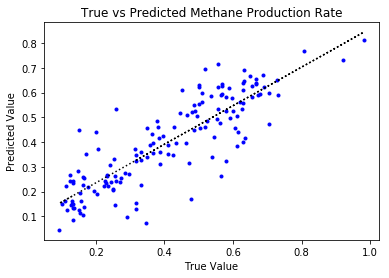

In [10]:
# Plot true vs predicted results
plt.plot(cv_results["Observed"], cv_results["Prediction"], "b.");
plt.xlabel("True Value"); plt.ylabel("Predicted Value"); plt.title("True vs Predicted Methane Production Rate");
m, b, r_value, p_value, std_err = stats.linregress(cv_results["Observed"], cv_results["Prediction"])
fit = np.multiply(cv_results["Observed"], m)+b
plt.plot(cv_results["Observed"], fit,"k:");